In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, cohen_kappa_score, log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import CoherenceModel
import tmtoolkit
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

## EDA

In [5]:
# uploaded datasets to dropbox instead because file sizes are too large (~ 1GB)

toxic_train = pd.read_csv("https://www.dropbox.com/s/8nqzj2glur4xyw1/toxic_train.csv?dl=1")
toxic_test = pd.read_csv("https://www.dropbox.com/s/9wgt22a8vfdf1a5/toxic_test.csv?dl=1")

# toxic_train = pd.read_csv("datasets/toxic_train.csv")
# toxic_test = pd.read_csv("datasets/toxic_test.csv")

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
toxic_train.head()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [7]:
toxic_test.head()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [8]:
toxic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
toxic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# check for null values

toxic_train.isnull().sum()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [11]:
# check for null values

toxic_test.isnull().sum()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id              0
comment_text    0
dtype: int64

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


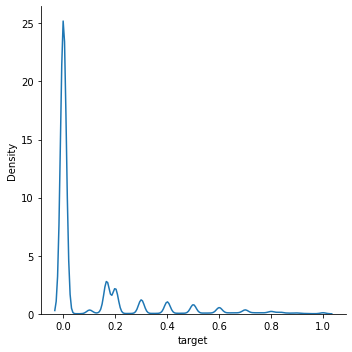

In [12]:
# Plot target feature distribution

sns.displot(toxic_train['target'], kind="kde")
plt.show()

# Most comments are non-toxic (< 0.5)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


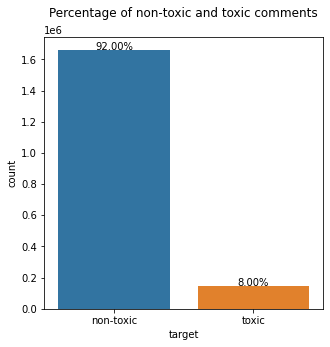

In [13]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = toxic_train['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(x=temp)
cntplot.set_title('Percentage of non-toxic and toxic comments', pad=20)

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

# dataset appears imbalanced with more non-toxic than toxic (can be dealt by undersampling / oversampling / SMOTE)

In [14]:
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
toxic_labeled_df = toxic_train.loc[:, ['target'] + identities ].dropna()

# if score > 0.5, can consider as toxic

toxic_df = toxic_labeled_df[toxic_labeled_df['target'] >= .5][identities]
non_toxic_df = toxic_labeled_df[toxic_labeled_df['target'] < .5][identities]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.

toxic_count = toxic_df.where(toxic_labeled_df == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(toxic_labeled_df == 0, other = 1).sum()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


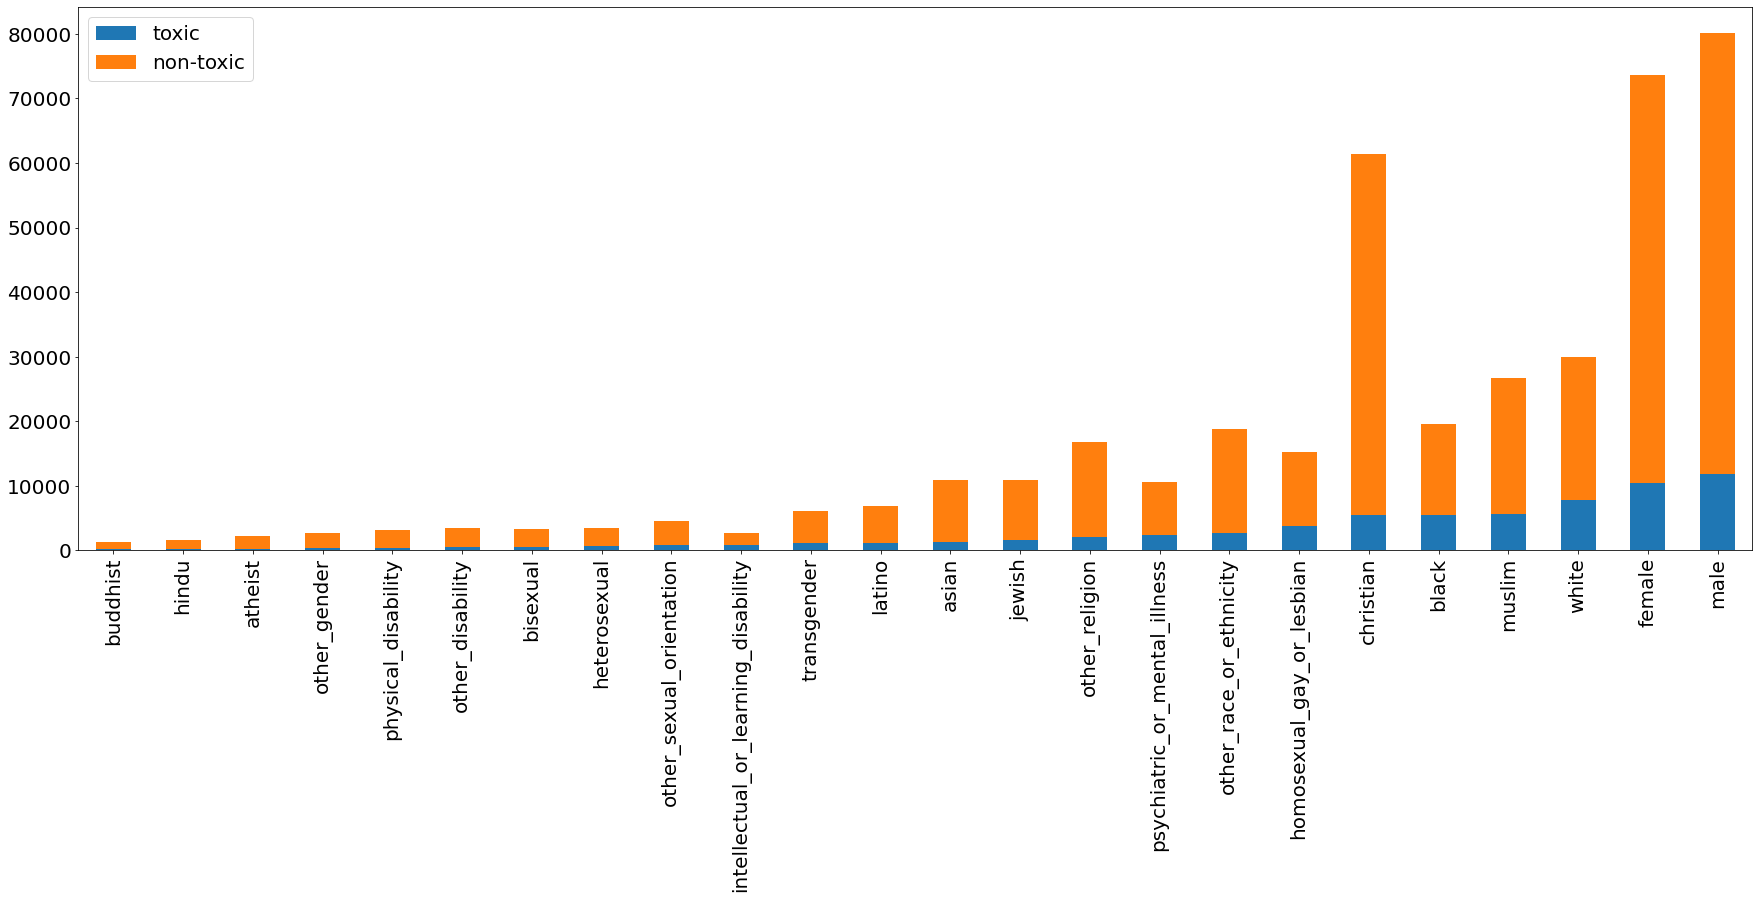

In [17]:
# now we can concat the two series together to get a toxic count vs non toxic count for each identity

toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})
plt.show()

**Correlation of Identities
(Identify if comments were about one group or just one identity)**

**For Toxic Comments**

In [18]:
toxic_df.corr()["male"].sort_values(ascending = False)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


male                                   1.000000
female                                 0.251032
white                                  0.093315
heterosexual                           0.079224
homosexual_gay_or_lesbian              0.047570
transgender                            0.032546
black                                  0.022581
bisexual                               0.016136
other_sexual_orientation               0.011243
physical_disability                    0.009453
other_disability                       0.003717
other_gender                          -0.000985
hindu                                 -0.006054
intellectual_or_learning_disability   -0.008745
atheist                               -0.009451
latino                                -0.012586
buddhist                              -0.016511
other_religion                        -0.020685
other_race_or_ethnicity               -0.021788
christian                             -0.024229
psychiatric_or_mental_illness         -0

In [19]:
toxic_df.corr()["homosexual_gay_or_lesbian"].sort_values(ascending = False)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


homosexual_gay_or_lesbian              1.000000
heterosexual                           0.234602
bisexual                               0.168542
transgender                            0.130152
other_sexual_orientation               0.111654
christian                              0.096497
other_gender                           0.055825
male                                   0.047570
other_religion                         0.031171
female                                 0.020832
jewish                                 0.016437
atheist                                0.006786
muslim                                 0.006350
hindu                                  0.005961
physical_disability                    0.005284
latino                                 0.003951
buddhist                               0.002545
other_disability                       0.002321
other_race_or_ethnicity               -0.010379
asian                                 -0.019550
intellectual_or_learning_disability   -0

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \*
<>:11: DeprecationWarning: invalid escape sequence \*
<ipython-input-21-00db93edd58b>:11: DeprecationWarning: invalid escape sequence \*
  text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations


In [23]:
# load preprocessed file

toxic_only_train_shortlisted = pd.read_csv('datasets/toxic_only_train_shortlisted_preprocessed.csv')
toxic_only_train_shortlisted

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,comment_text,target,preprocessed_text
0,4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser
1,5,ur a sh*tty comment.,None,ur sh * tty comment
2,13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...
3,14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love people sending ...
4,19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...
...,...,...,...,...
144329,1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e
144330,1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...
144331,1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...
144332,1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...


# Word Clouds

In [34]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
toxic_only_train_shortlisted["target"].value_counts()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


None          110514
Gender         14521
Race           10259
Religion        7409
Disability      1631
Name: target, dtype: int64

#### General Word Cloud

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


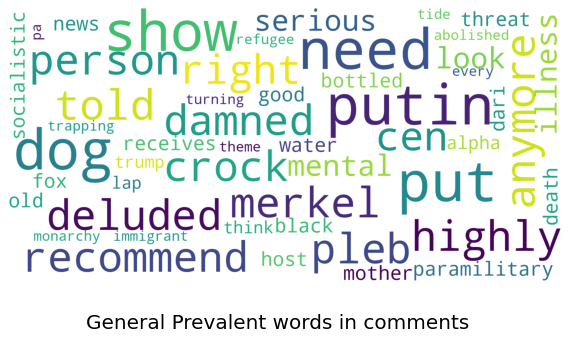

In [36]:
show_wordcloud(toxic_only_train_shortlisted['preprocessed_text'].sample(20000, random_state = 42), title = 'General Prevalent words in comments')

#### None Category Word Cloud

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


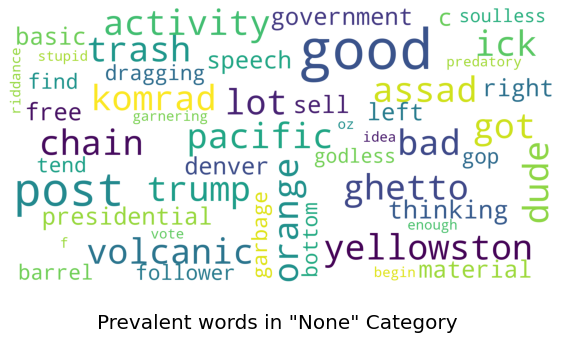

In [37]:
show_wordcloud(toxic_only_train_shortlisted[toxic_only_train_shortlisted["target"] == "None"]["preprocessed_text"].sample(20000, random_state = 42), title = 'Prevalent words in "None" Category')

#### Gender Category Word Cloud

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


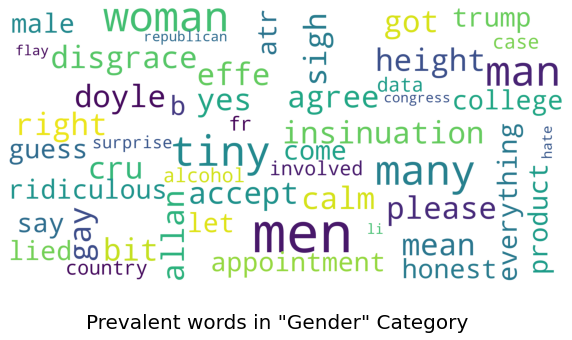

In [38]:
show_wordcloud(toxic_only_train_shortlisted[toxic_only_train_shortlisted["target"] == "Gender"]["preprocessed_text"].sample(7000, random_state = 42), title = 'Prevalent words in "Gender" Category')

#### Race Category Word Cloud

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


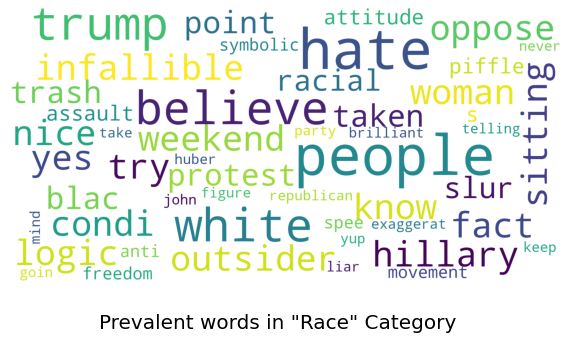

In [39]:
show_wordcloud(toxic_only_train_shortlisted[toxic_only_train_shortlisted["target"] == "Race"]["preprocessed_text"].sample(5000, random_state = 42), title = 'Prevalent words in "Race" Category')

#### Religion Category Word Cloud

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


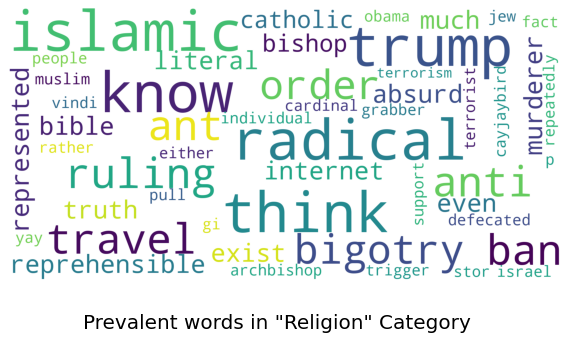

In [40]:
show_wordcloud(toxic_only_train_shortlisted[toxic_only_train_shortlisted["target"] == "Religion"]["preprocessed_text"].sample(4000, random_state = 42), title = 'Prevalent words in "Religion" Category')

#### Disability Category Word Cloud

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


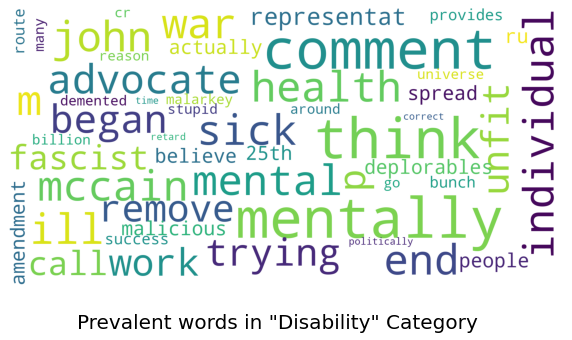

In [41]:
show_wordcloud(toxic_only_train_shortlisted[toxic_only_train_shortlisted["target"] == "Disability"]["preprocessed_text"].sample(1000, random_state = 42), title = 'Prevalent words in "Disability" Category')

# Classification Models (Task 1)

In [58]:
# load preprocessed file

# toxic_only_train_shortlisted = pd.read_pickle('datasets/toxic_only_train_shortlisted_preprocessed.pkl')
# toxic_only_train_shortlisted
toxic_only_train_shortlisted = pd.read_csv('datasets/toxic_only_train_shortlisted_preprocessed.csv')
toxic_only_train_shortlisted

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,comment_text,target,preprocessed_text
0,4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser
1,5,ur a sh*tty comment.,None,ur sh * tty comment
2,13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...
3,14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love people sending ...
4,19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...
...,...,...,...,...
144329,1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e
144330,1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...
144331,1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...
144332,1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...


In [59]:
X = toxic_only_train_shortlisted["preprocessed_text"]
y = toxic_only_train_shortlisted["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train.values.astype('U'))
tfidf_test = tfidf_vec.transform(X_test.values.astype('U'))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# to facilitate the plotting of ROCAUC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=["Disability", "Gender", "None", "Race", "Religion"])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Logistic Regression

In [68]:
logreg = LogisticRegression(C = 5, random_state = 42, solver = 'sag', max_iter = 1000, n_jobs = -1)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
pd.Series(y_pred).value_counts()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


None          35045
Gender         3431
Race           2661
Religion       1905
Disability      259
dtype: int64

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_plot\confusion_matrix.py:162: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(self.im_, ax=ax)
<ipython-input-70-74212e57a1c2>:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = None)


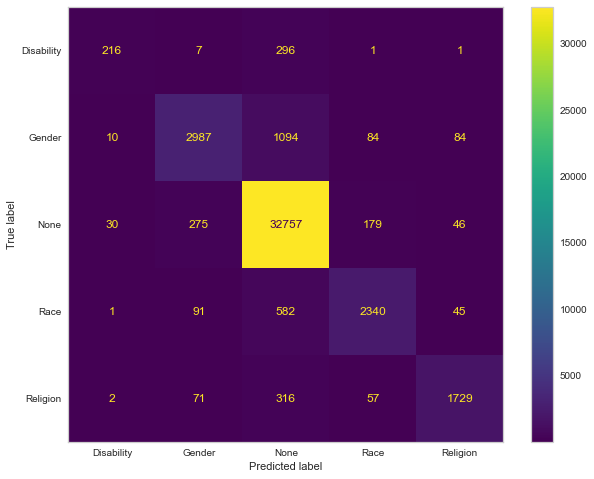

In [70]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Disability", "Gender", "None", "Race", "Religion"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [71]:
print(classification_report(y_test, y_pred))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

  Disability       0.83      0.41      0.55       521
      Gender       0.87      0.70      0.78      4259
        None       0.93      0.98      0.96     33287
        Race       0.88      0.76      0.82      3059
    Religion       0.91      0.79      0.85      2175

    accuracy                           0.92     43301
   macro avg       0.89      0.73      0.79     43301
weighted avg       0.92      0.92      0.92     43301



C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


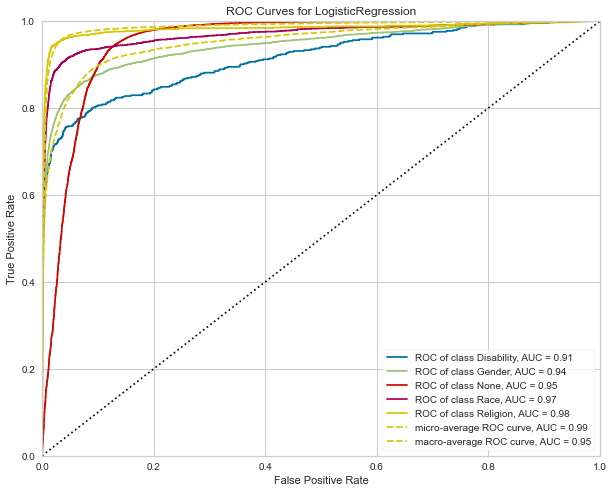

In [72]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(logreg, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

In [73]:
# Matthew's correlation coefficient

matthews_corrcoef(y_test, y_pred)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7970757364946978

In [74]:
# Cohen's kappa

cohen_kappa_score(y_test, y_pred)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7920746970164828

In [75]:
# log loss

y_preb_probs = logreg.predict_proba(tfidf_test)
log_loss(y_test, y_preb_probs)# test for random sentence

sent = ["haha you are all losers"]
sent_transformed = tfidf_vec.transform(sent)
test_pred = logreg.predict(sent_transformed)
test_pred[0]

sent_2 = ["this woman is a bitch"]
sent_transformed_2 = tfidf_vec.transform(sent_2)
test_pred_2 = logreg.predict(sent_transformed_2)
test_pred_2[0]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2581075593350524

In [17]:
# test for general sentence

sent = ["haha you are all losers"]
sent_transformed = tfidf_vec.transform(sent)
test_pred = logreg.predict(sent_transformed)
test_pred[0]

'None'

In [18]:
# test for gender sentence

sent_2 = ["this woman is a bitch"]
sent_transformed_2 = tfidf_vec.transform(sent_2)
test_pred_2 = logreg.predict(sent_transformed_2)
test_pred_2[0]

'Gender'

## Multinomial NB

In [76]:
MLNB = MultinomialNB()
MLNB.fit(tfidf_train, y_train)
y_pred = MLNB.predict(tfidf_test)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_plot\confusion_matrix.py:162: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(self.im_, ax=ax)
<ipython-input-77-74212e57a1c2>:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = None)


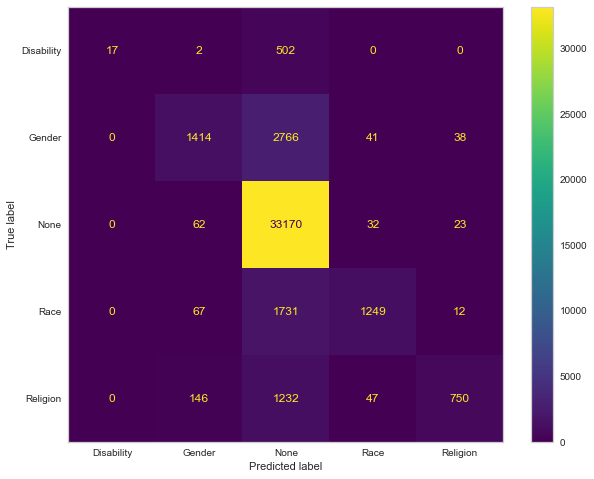

In [77]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Disability", "Gender", "None", "Race", "Religion"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [78]:
print(classification_report(y_test, y_pred))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

  Disability       1.00      0.03      0.06       521
      Gender       0.84      0.33      0.48      4259
        None       0.84      1.00      0.91     33287
        Race       0.91      0.41      0.56      3059
    Religion       0.91      0.34      0.50      2175

    accuracy                           0.85     43301
   macro avg       0.90      0.42      0.50     43301
weighted avg       0.85      0.85      0.81     43301



C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


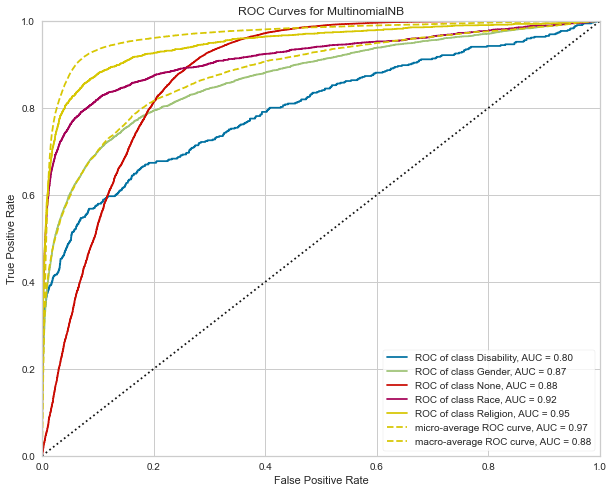

In [79]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(MLNB, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

In [80]:
# Matthew's correlation coefficient

matthews_corrcoef(y_test, y_pred)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5389146447758433

In [81]:
# Cohen's kappa

cohen_kappa_score(y_test, y_pred)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.47267307599803765

In [82]:
# log loss

y_preb_probs = MLNB.predict_proba(tfidf_test)
log_loss(y_test, y_preb_probs)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.489314572940579

## LSTM

In [90]:
train_sentence = []
test_sentence = []
for row in X_train.to_numpy():
    train_sentence.append(str(row))
for row in X_test.to_numpy():
    test_sentence.append(str(row))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
max_words = 30000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentence)
sequences = tok.texts_to_sequences(train_sentence)
X_train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_train_sequences_matrix

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[    0,     0,     0, ...,    47,  1502,   700],
       [    0,     0,     0, ...,   223, 14765,  1122],
       [    0,     0,     0, ...,  1049,   183,    75],
       ...,
       [    0,     0,     0, ...,   516,  2428, 22891],
       [    0,     0,     0, ...,    84,    88,  1118],
       [    0,     0,     0, ...,   343,   127,  1174]])

In [93]:
tok.fit_on_texts(test_sentence)
sequences = tok.texts_to_sequences(test_sentence)
X_test_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_test_sequences_matrix

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[   0,    0,    0, ...,  894,   82, 4260],
       [   0,    0,    0, ...,   20,  581, 2191],
       [   0,    0,    0, ..., 1229, 1443,  558],
       ...,
       [   0,    0,    0, ...,  899,   40, 3075],
       [   0,    0,    0, ..., 6010,  674, 1025],
       [   0,    0,    0, ..., 4683,  506, 2239]])

In [94]:
y_train_2 = []
for i in y_train.to_numpy():
    if i=="Race":
        y_train_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_train_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_train_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_train_2.append([0,0,0,1,0])
    else:
        y_train_2.append([0,0,0,0,1])
y_train_2 = np.array(y_train_2)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
y_test_2 = []
for i in y_test.to_numpy():
    if i=="Race":
        y_test_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_test_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_test_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_test_2.append([0,0,0,1,0])
    else:
        y_test_2.append([0,0,0,0,1])
y_test_2 = np.array(y_test_2)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
model = Sequential()
model.add(Embedding(30000, 50, input_length=X_train_sequences_matrix.shape[1]))
model.add(LSTM(100,activation='tanh',recurrent_activation = "sigmoid", dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_sequences_matrix, y_train_2, epochs=3, batch_size=5)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           1500000   
                                                                 
 lstm (LSTM)                 (None, 200, 100)          60400     
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 5)                 100005    
                                                                 
Total params: 1,660,405
Trainable params: 1,660,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
20207/20207 [==============================] - 244s 12ms/step - loss: 0.3105 - accuracy: 0.9122
Epoch 2/3
20207/20207 [==============================] - 262s 13ms/

In [97]:
scores = model.evaluate(X_test_sequences_matrix, y_test_2, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss:" +str (scores[0]))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 65.37%
Loss:1.7655973434448242


In [98]:
y_pred = model.predict(X_test_sequences_matrix)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
y_pred_2 = []

for lst in y_pred:
    max_val = 0
    for i, val in enumerate(lst):
        if val>max_val:
            max_val=val
            ind=i
    y_pred_2.append(ind)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
y_pred_3 = []
for i in y_pred_2:
    if i==0:
        y_pred_3.append("Race")
    elif i==1:
        y_pred_3.append("Gender")
    elif i==2:
        y_pred_3.append("Religion")
    elif i==3:
        y_pred_3.append("Disability")
    else:
        y_pred_3.append("None")


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
y_pred_4 = []
for i in y_pred_2:
    if i==0:
        y_pred_4.append([1,0,0,0,0])
    elif i==1:
        y_pred_4.append([0,1,0,0,0])
    elif i==2:
        y_pred_4.append([0,0,1,0,0])
    elif i==3:
        y_pred_4.append([0,0,0,1,0])
    else:
        y_pred_4.append([0,0,0,0,1])
y_pred_4 = np.array(y_pred_4)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_plot\confusion_matrix.py:162: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(self.im_, ax=ax)
<ipython-input-102-c048443aafc9>:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = None)


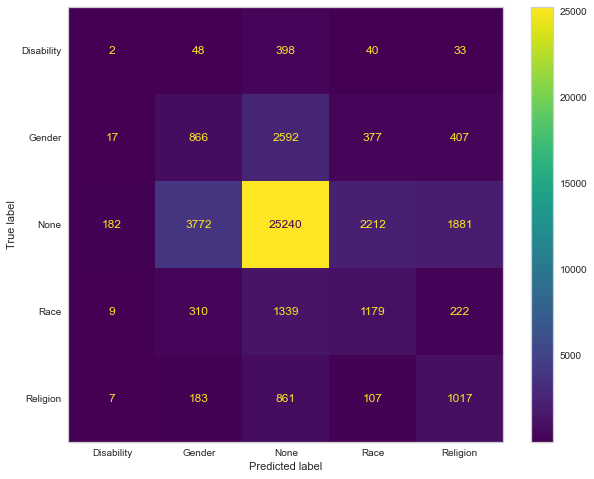

In [102]:
y_pred_5 = [y_pred_3[3], y_pred_3[1],y_pred_3[4],y_pred_3[0],y_pred_3[2]]
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred_3)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Disability", "Gender", "None", "Race", "Religion"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


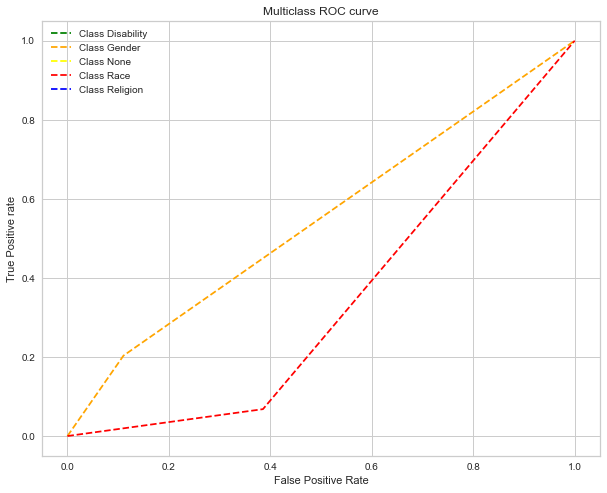

In [103]:
fpr = {}
tpr = {}
thresh ={}
n_class = ["Disability", "Gender", "None", "Race", "Religion"]
for i in range(len(n_class)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_2[:,i], y_pred_4[:,i], pos_label=i)
# plotting    
plt.plot(fpr[3], tpr[3], linestyle='--',color='green', label='Class Disability')
plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label='Class Gender')
plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Class None')
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Class Race ')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Religion')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [104]:
# Matthew's correlation coefficient

matthews_corrcoef(y_test, y_pred_3)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.21074300505890162

In [105]:
# Cohen's kappa

cohen_kappa_score(y_test, y_pred_3)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2082251051542402

# LDA (Task 2)

In [107]:
toxic_only_train_shortlisted = pd.read_csv('datasets/toxic_only_train_shortlisted_preprocessed.csv')

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
stop_words = stopwords.words('english')
stop_words.extend(['com', 'http', 'wwww', 'like', 'say', 'need', 'good', 'want', 'people', 'know', 'right', 'make', 'thing'])
lemmatizer = WordNetLemmatizer()
# print(stop_words)

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:8: DeprecationWarning: invalid escape sequence \*
<>:8: DeprecationWarning: invalid escape sequence \*
<ipython-input-108-0db2e1d3704e>:8: DeprecationWarning: invalid escape sequence \*
  text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations


In [109]:
toxic_only_train_shortlisted["preprocessed_text"] = toxic_only_train_shortlisted["comment_text"].apply(preprocesstext)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['trump', 'stupid', 'time', 'think', 'white', 'year', 'country', 'way', 'woman', 'idiot', 'president', 'really', 'black', 'american', 'liberal', 'state', 'going', 'racist', 'man', 'comment']


C:\Users\wei-d\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


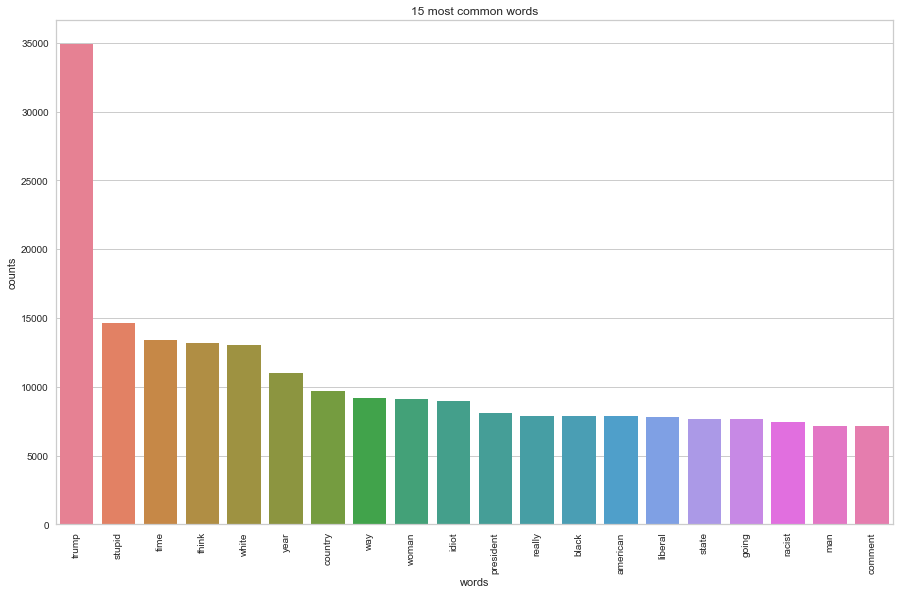

In [110]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='15 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
#     plt.show()
    print(words)

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(toxic_only_train_shortlisted['preprocessed_text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Sklearn LDA

In [111]:
lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text']
tokenized_docs = [word_tokenize(doc) for doc in lda_preprocessed_comments]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:
count_vectoriser = CountVectorizer()
lda_count_vecs = count_vectoriser.fit_transform(list(lda_preprocessed_comments))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
vocab_list = np.array([x for x in count_vectoriser.vocabulary_.keys()])


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:

sklearn_model_list = []
sklearn_perplexity_values = []
sklearn_model_topics = []
sklearn_coherence_values= []

for num_topics in range(2, 20, 2):
    sklearn_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
    output_x = sklearn_lda_x.fit_transform(lda_count_vecs)
    sklearn_model_topics.append(num_topics)
    sklearn_model_list.append(sklearn_lda_x)
    perplexity_x = sklearn_lda_x.perplexity(lda_count_vecs)
    sklearn_perplexity_values.append(perplexity_x)
    coherence_x = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=sklearn_lda_x.components_, 
                        dtm=output_x,
                        vocab=vocab_list, 
                        texts=tokenized_docs,
                        return_mean = True)
    sklearn_coherence_values.append(coherence_x)
    print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x) + ", Coherence Score: " + str(coherence_x))


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 2, Perplexity Score: 4790.394019453048, Coherence Score: 0.839962441216882
#Topics: 4, Perplexity Score: 5000.86627098783, Coherence Score: 0.8293721037355726
#Topics: 6, Perplexity Score: 5440.536104991522, Coherence Score: 0.8254763331627722
#Topics: 8, Perplexity Score: 5828.048562612324, Coherence Score: 0.8092142954794601
#Topics: 10, Perplexity Score: 6073.188533823387, Coherence Score: 0.7573433510854668
#Topics: 12, Perplexity Score: 6394.53918996156, Coherence Score: 0.7909502331411905
#Topics: 14, Perplexity Score: 6819.400931804571, Coherence Score: 0.7942942032702343
#Topics: 16, Perplexity Score: 7030.9565843209675, Coherence Score: 0.7470565218727444
#Topics: 18, Perplexity Score: 7213.996941722472, Coherence Score: 0.7412138187969208


### sklearn 5 topics

In [115]:
num_topics = 5
sklearn_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
output_x = sklearn_lda_x.fit_transform(lda_count_vecs)
perplexity_x = sklearn_lda_x.perplexity(lda_count_vecs)
coherence_x = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                    top_n=25, 
                    topic_word_distrib=sklearn_lda_x.components_, 
                    dtm=output_x,
                    vocab=vocab_list, 
                    texts=tokenized_docs,
                    return_mean = True)
# sklearn_coherence_values.append(coherence_x)
print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x) + ", Coherence Score: " + str(coherence_x))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 5, Perplexity Score: 5272.7126729592665, Coherence Score: 0.8244687303714763


### sklearn 7 topics

In [116]:
num_topics = 7
sklearn_lda_x2 = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
output_x2 = sklearn_lda_x2.fit_transform(lda_count_vecs)
perplexity_x2 = sklearn_lda_x2.perplexity(lda_count_vecs)
coherence_x2 = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                    top_n=25, 
                    topic_word_distrib=sklearn_lda_x2.components_, 
                    dtm=output_x2,
                    vocab=vocab_list, 
                    texts=tokenized_docs,
                    return_mean = True)
print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x2) + ", Coherence Score: " + str(coherence_x2))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 7, Perplexity Score: 5673.09522603862, Coherence Score: 0.8027706487761112


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


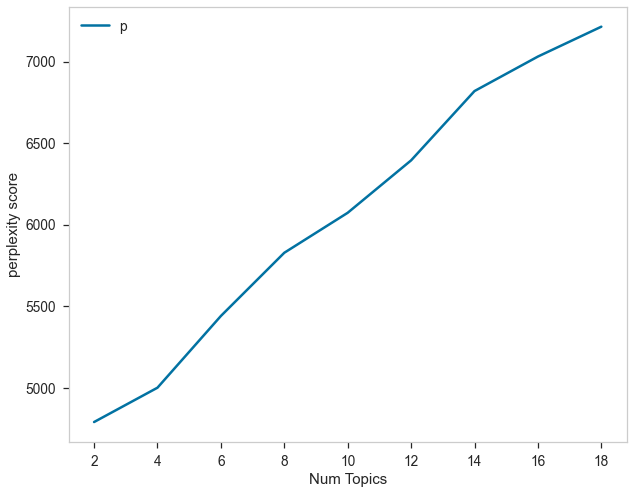

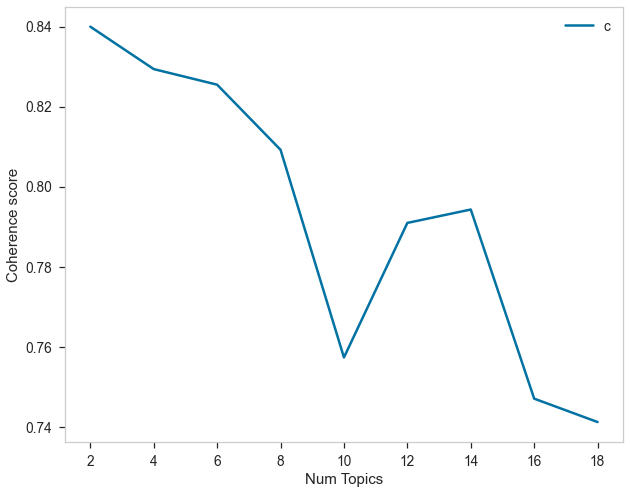

In [117]:
import matplotlib.pyplot as plt

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, sklearn_perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.grid()
plt.show()
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, sklearn_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [120]:
# Generate the visuals
visual = pyLDAvis.sklearn.prepare(sklearn_lda_x, lda_count_vecs, count_vectoriser, mds='tsne')
visual

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\wei-d\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sn

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  31.898847
2       51.163364 -159.968018       2        1  25.163936
1      -73.144554   21.523815       3        1  15.433422
3      -66.410133 -110.606438       4        1  15.085792
0       54.417324   12.443444       5        1  12.418003, topic_info=        Term          Freq         Total Category  logprob  loglift
65699  trump  34192.000000  34192.000000  Default  30.0000  30.0000
70194  white  13723.000000  13723.000000  Default  29.0000  29.0000
70818  woman   8747.000000   8747.000000  Default  28.0000  28.0000
27160    get  18416.000000  18416.000000  Default  27.0000  27.0000
8581   black   8510.000000   8510.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
38687  loser   1965.992983   3728.888776   Topic5  -5.3946   1.4459
37459  

In [119]:
# Generate the visuals
visual = pyLDAvis.sklearn.prepare(sklearn_lda_x2, lda_count_vecs, count_vectoriser, mds='tsne')
visual

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\wei-d\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sn

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1     -29.594002  60.112713       1        1  17.138290
5     -45.996586  11.891685       2        1  16.803663
0      20.368856  70.019325       3        1  16.601261
6      53.928768  31.704309       4        1  14.995855
2     -12.437127 -26.423267       5        1  12.354064
4       3.965971  21.797720       6        1  12.254575
3      37.524284 -16.517805       7        1   9.852293, topic_info=             Term          Freq         Total Category  logprob  loglift
65699       trump  33979.000000  33979.000000  Default  30.0000  30.0000
70194       white  13782.000000  13782.000000  Default  29.0000  29.0000
15558     country   9901.000000   9901.000000  Default  28.0000  28.0000
70818       woman   8785.000000   8785.000000  Default  27.0000  27.0000
8581        black   8475.000000   8475.000000  Default  26.0000  26.0000
...           .

### Gensim LDA

In [126]:
def lda_preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
toxic_only_train_shortlisted = pd.read_csv('datasets/toxic_only_train_shortlisted_preprocessed.csv')
gensim_lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text'].astype(str).map(lda_preprocess)
dictionary = corpora.Dictionary(gensim_lda_preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)
bow_corpus = [dictionary.doc2bow(doc) for doc in gensim_lda_preprocessed_comments]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
# find optimal k (no. of topics) and plot graph visually

model_list = []
perplexity_values = []
coherence_values = []
model_topics = []

for i in range(2, 20, 2):
    print("--------Topics: " + str(i) +'----------')
    lda_model = models.LdaMulticore(bow_corpus, num_topics=i,id2word=dictionary, passes=2, workers=2)
#     lda_model.fit_transform(bow_corpus)
    model_topics.append(i)
    model_list.append(lda_model)
    perplexity_cal = np.exp(-1. * lda_model.log_perplexity(bow_corpus))
    perplexity_values.append(perplexity_cal)
    print("#Topics: " + str(i) + ", Perplexity Score: " + str(perplexity_cal))
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=gensim_lda_preprocessed_comments,dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print("#Topics: " + str(i) + ', Coherence Score: ', coherence_lda)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------Topics: 2----------
#Topics: 2, Perplexity Score: 3526.4891559114894
#Topics: 2, Coherence Score:  0.3880503170879375
--------Topics: 4----------
#Topics: 4, Perplexity Score: 3579.4900069620066
#Topics: 4, Coherence Score:  0.46676524306568334
--------Topics: 6----------
#Topics: 6, Perplexity Score: 3619.201952347442
#Topics: 6, Coherence Score:  0.5011990986381902
--------Topics: 8----------
#Topics: 8, Perplexity Score: 3843.5940266182442
#Topics: 8, Coherence Score:  0.5295219607869385
--------Topics: 10----------
#Topics: 10, Perplexity Score: 4499.162842827843
#Topics: 10, Coherence Score:  0.5124620391826388
--------Topics: 12----------
#Topics: 12, Perplexity Score: 5326.165939491675
#Topics: 12, Coherence Score:  0.5393731588068943
--------Topics: 14----------
#Topics: 14, Perplexity Score: 6008.835533353871
#Topics: 14, Coherence Score:  0.5330159579983863
--------Topics: 16----------
#Topics: 16, Perplexity Score: 6710.299121053756
#Topics: 16, Coherence Score:  0.5

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


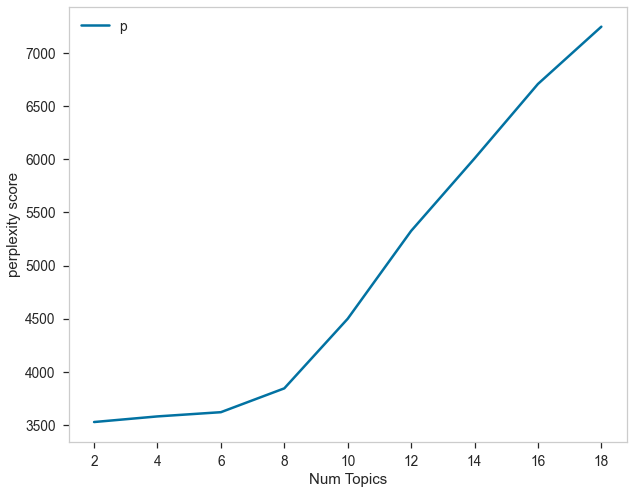

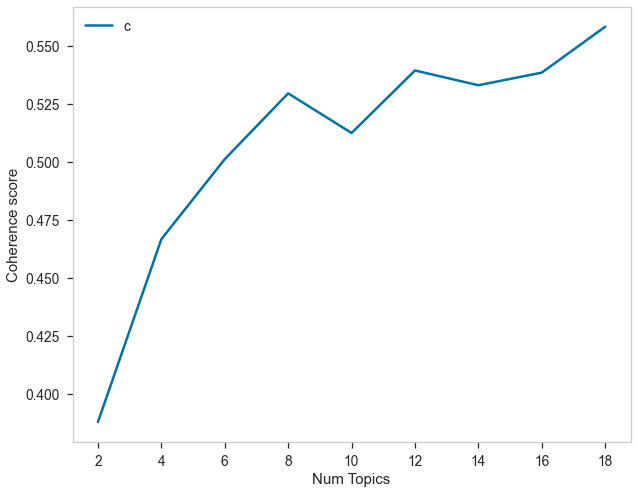

In [129]:

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.grid()
plt.show()
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [132]:
# Generate the visuals
visual = pyLDAvis.gensim_models.prepare(model_list[2], bow_corpus, dictionary = model_list[2].id2word, mds='tsne')
visual

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4       1.465019 -47.625065       1        1  18.831644
2      54.854797 -36.476795       2        1  18.516943
0      32.212929 -61.444572       3        1  18.283611
5       5.111096 -14.110332       4        1  17.168446
1      26.350170 -33.374702       5        1  16.482180
3      38.109818  -7.222781       6        1  10.717176, topic_info=           Term          Freq         Total Category  logprob  loglift
465       trump  33933.000000  33933.000000  Default  30.0000  30.0000
163       white  14829.000000  14829.000000  Default  29.0000  29.0000
765         tax   6669.000000   6669.000000  Default  28.0000  28.0000
1145  president   8732.000000   8732.000000  Default  27.0000  27.0000
43       racist   8389.000000   8389.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
47         w

### Final sklearn LDA - 6 topics

In [136]:
num_topics = 6
sklearn_lda_x3 = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1, random_state = 42)
output_x3 = sklearn_lda_x3.fit_transform(lda_count_vecs)
# sklearn_model_topics.append(num_topics)
# sklearn_model_list.append(sklearn_lda_x3)
perplexity_x3 = sklearn_lda_x3.perplexity(lda_count_vecs)
# sklearn_perplexity_values.append(perplexity_x3)
coherence_x3 = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                    top_n=25, 
                    topic_word_distrib=sklearn_lda_x3.components_, 
                    dtm=output_x3,
                    vocab=vocab_list, 
                    texts=tokenized_docs,
                    return_mean = True)
# sklearn_coherence_values.append(coherence_x3)
print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x3) + ", Coherence Score: " + str(coherence_x3))

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 6, Perplexity Score: 5492.096829862967, Coherence Score: 0.8166816831328085


In [137]:
selected_lda_model = sklearn_lda_x3
for x, topic in enumerate(selected_lda_model.components_):
    print("topic", x)
    print(topic)

topic 0
[1.68548400e-01 4.09855556e+02 1.68404748e-01 ... 2.88014073e+00
 1.73884253e-01 1.20040168e+00]
topic 1
[0.1675359  0.16808399 0.16675082 ... 0.16749578 0.17180581 0.16667155]
topic 2
[0.16794178 0.16831949 0.16722892 ... 0.16742886 0.17238691 0.16667073]
topic 3
[0.16716956 0.16778414 0.16688344 ... 0.16713194 0.16667043 0.16666926]
topic 4
[0.16747368 2.76486764 0.16689168 ... 0.16722336 0.16667383 0.1693498 ]
topic 5
[1.85708292e+02 9.85217678e+02 4.56397428e+00 ... 1.67194208e-01
 1.62488107e+00 1.66668529e-01]


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
lda_output = selected_lda_model.transform(lda_count_vecs)

# column names
topicnames = ["Topic" + str(i) for i in range(sklearn_lda_x3.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(lda_preprocessed_comments))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
num_doc_to_show = 10  # change this to display the number of documents shown below
df_document_topics = df_document_topic.head(num_doc_to_show).style.applymap(color_green).applymap(make_bold)
df_document_topics

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.033640,0.033500,0.033550,0.832110,0.033330,0.033860,3
Doc1,0.033620,0.033330,0.433250,0.233080,0.233390,0.033330,2
Doc2,0.016740,0.016680,0.016760,0.788310,0.144800,0.016710,3
Doc3,0.008850,0.008780,0.125510,0.008850,0.008780,0.839230,5
Doc4,0.053840,0.005140,0.067300,0.259560,0.005070,0.609110,5
Doc5,0.010520,0.134530,0.010500,0.010450,0.727490,0.106510,4
Doc6,0.023860,0.023810,0.024360,0.446440,0.023820,0.457710,5
Doc7,0.089560,0.002170,0.002180,0.002170,0.409470,0.494450,5
Doc8,0.950870,0.009810,0.009840,0.009830,0.009820,0.009830,0
Doc9,0.053050,0.029970,0.070490,0.004080,0.004070,0.838340,5


In [139]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vectoriser, lda_model=selected_lda_model, n_words=10):
    keywords = np.array(count_vectoriser.get_feature_names())
    topic_keywords = []
    for topic_weights in selected_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectoriser, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,stupid,get,time,would,go,year,think,pathetic,one,take
Topic 1,country,canada,liberal,lie,canadian,war,left,head,trudeau,side
Topic 2,woman,child,family,gay,men,kid,sex,gun,life,kill
Topic 3,trump,white,black,president,racist,one,would,man,comment,hate
Topic 4,muslim,law,terrorist,christian,russian,call,question,god,ignorance,claim
Topic 5,trump,get,one,would,money,tax,idiot,going,republican,stupid


In [140]:
feature_names = count_vectoriser.get_feature_names()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [141]:
# write a function to display the 10 topics and for each topic we choose the top most frequent words. 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 15
display_topics(selected_lda_model, feature_names, 15)

Topic 0:
stupid get time would go year think pathetic one take really back problem even well
Topic 1:
country canada liberal lie canadian war left head trudeau side american right lol wing military
Topic 2:
woman child family gay men kid sex gun life kill one sexual crime would get
Topic 3:
trump white black president racist one would man comment hate think person loser fact medium
Topic 4:
muslim law terrorist christian russian call question god ignorance claim illegal church blame religion state
Topic 5:
trump get one would money tax idiot going republican stupid state keep government fool time


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Sub-topic distribution across documents


In [142]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic analysis 


In [143]:
df_document_topic_view = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)
df_document_topic_view['dominant_topic'] = dominant_topic

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Topic 0

In [144]:
df_document_topic_view.sort_values("Topic0", ascending = False).head(10)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc20617,0.98053,0.00388,0.00389,0.00389,0.00391,0.00391,0
Doc71418,0.97437,0.00055,0.00055,0.02344,0.00055,0.00055,0
Doc61,0.96645,0.00676,0.00669,0.00673,0.00667,0.00670,0
Doc42,0.96366,0.00728,0.00726,0.00726,0.00727,0.00728,0
Doc77198,0.95341,0.00929,0.00932,0.00932,0.00930,0.00937,0
Doc8,0.95087,0.00981,0.00984,0.00983,0.00982,0.00983,0
Doc1445,0.94779,0.01043,0.01047,0.01045,0.01043,0.01044,0
Doc1444,0.94779,0.01043,0.01047,0.01045,0.01043,0.01044,0
Doc3856,0.94767,0.01051,0.01044,0.01047,0.01044,0.01047,0
Doc60631,0.94766,0.01045,0.01047,0.01044,0.01056,0.01043,0


In [145]:
toxic_only_train_shortlisted["comment_text"].iloc[8]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"Love that they also participate in the Portland Farmer's Market at PSU... and trying to gluten-shame Tastebud and propping Papa Murphy's in the same sentence is laughable."

In [146]:
toxic_only_train_shortlisted["comment_text"].iloc[60631]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"I hope there aren't any stupid few Canarians who say the mountain is sacred. The few lolo Hawaiians ruin it for the many Hawaiians. Did I say the few lolo Hawaiians ruin it for the many Hawaiians?"

#### Topic 1

In [147]:
df_document_topic_view.sort_values("Topic1", ascending = False).head(10)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc72301,0.01670,0.91626,0.01683,0.01671,0.01677,0.01674,1
Doc42428,0.01858,0.90707,0.01856,0.01861,0.01859,0.01859,1
Doc17304,0.01882,0.90678,0.01852,0.01879,0.01852,0.01857,1
Doc74281,0.01897,0.90635,0.01865,0.01861,0.01852,0.01890,1
Doc60019,0.02083,0.89582,0.02085,0.02083,0.02083,0.02083,1
Doc46111,0.02087,0.89575,0.02086,0.02084,0.02083,0.02085,1
Doc33099,0.02084,0.89571,0.02083,0.02083,0.02087,0.02091,1
Doc26,0.02089,0.89570,0.02086,0.02085,0.02083,0.02086,1
Doc108643,0.02090,0.89551,0.02085,0.02088,0.02084,0.02103,1
Doc63283,0.02090,0.89548,0.02085,0.02102,0.02083,0.02091,1


In [148]:
toxic_only_train_shortlisted["comment_text"].iloc[46111]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Kellie Leitch is an embarrassment to pushy bone heads everywhere.'

In [149]:
toxic_only_train_shortlisted["comment_text"].iloc[108643]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'another Liberal zombie. Harper was great compared to this clown.'

#### Topic 2

In [150]:
df_document_topic_view.sort_values("Topic2", ascending = False).head(10)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc116531,0.01199,0.01192,0.94031,0.01195,0.01192,0.01192,2
Doc74460,0.01288,0.01285,0.93577,0.01282,0.01284,0.01285,2
Doc56562,0.01289,0.01282,0.93571,0.01285,0.01283,0.01290,2
Doc91448,0.01287,0.01284,0.93569,0.01288,0.01286,0.01285,2
Doc19789,0.01395,0.01398,0.93028,0.01392,0.01393,0.01394,2
Doc98,0.00606,0.04572,0.93021,0.00597,0.00596,0.00608,2
Doc32559,0.01668,0.01669,0.91658,0.01667,0.01668,0.01670,2
Doc61412,0.01674,0.01667,0.91649,0.01670,0.01667,0.01673,2
Doc131251,0.01678,0.01668,0.91643,0.01667,0.01669,0.01675,2
Doc118934,0.01681,0.01667,0.91634,0.01670,0.01673,0.01675,2


In [151]:
toxic_only_train_shortlisted["comment_text"].iloc[116531]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'A homosexual orientation is not a sin. Homosexual behavior is a sin, as well as heterosexual behavior outside of marriage is also a sin.'

In [152]:
toxic_only_train_shortlisted["comment_text"].iloc[91448]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"Some lesbians, but mostly by men.  Gays don't recruit.  Pederasts recruit - many in the priesthood and they become, gasp, priests."

#### Topic 3

In [153]:
df_document_topic_view.sort_values("Topic3", ascending = False).head(10)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc67138,0.00880,0.00878,0.00882,0.95601,0.00880,0.00879,3
Doc55749,0.00514,0.03833,0.00510,0.94123,0.00506,0.00514,3
Doc106870,0.01194,0.01190,0.01192,0.94037,0.01196,0.01191,3
Doc144109,0.01284,0.01282,0.01282,0.93586,0.01282,0.01284,3
Doc92835,0.01287,0.01287,0.01284,0.93569,0.01286,0.01287,3
Doc126830,0.01287,0.01285,0.01285,0.93566,0.01286,0.01291,3
Doc20290,0.01292,0.01283,0.01284,0.93553,0.01296,0.01291,3
Doc3397,0.01391,0.01391,0.01389,0.93044,0.01392,0.01392,3
Doc1029,0.01394,0.01392,0.01392,0.93036,0.01390,0.01395,3
Doc104579,0.01403,0.01389,0.01394,0.93032,0.01390,0.01393,3


In [154]:
toxic_only_train_shortlisted["comment_text"].iloc[67138]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Mr.Marr and his Neo-Nazi friends are equal parts digusting and pitiful.  "The Holocaust is Hokum" says it all........ again equal parts....nasty and ignorant.  Gary \nCrum'

In [155]:
toxic_only_train_shortlisted["comment_text"].iloc[106870]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'http://www.cavalierdaily.com/article/2016/11/wes-bellamy-charlottesville-twitter\n\nRead up on Bellamy, he is a black supremacist.'

#### Topic 4

In [156]:
df_document_topic_view.sort_values("Topic4", ascending = False).head(10)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc121570,0.00172,0.00172,0.00172,0.00173,0.99140,0.00172,4
Doc136360,0.01561,0.01572,0.01519,0.01546,0.92278,0.01524,4
Doc26862,0.01857,0.01856,0.01869,0.01890,0.90664,0.01864,4
Doc87,0.00192,0.00191,0.01728,0.03840,0.90293,0.03756,4
Doc85853,0.02134,0.02083,0.02102,0.02096,0.89475,0.02109,4
Doc137110,0.02383,0.02382,0.02382,0.02401,0.88070,0.02382,4
Doc18,0.02396,0.02381,0.02391,0.02396,0.88044,0.02392,4
Doc2185,0.02396,0.02381,0.02391,0.02396,0.88044,0.02392,4
Doc8112,0.02396,0.02381,0.02391,0.02396,0.88044,0.02392,4
Doc6135,0.02396,0.02381,0.02391,0.02396,0.88044,0.02392,4


In [157]:
toxic_only_train_shortlisted["comment_text"].iloc[26862]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Marty, you have repeatedly shown your ignorance of Church history. What you do "know" is extremely revisionistic.'

In [158]:
toxic_only_train_shortlisted["comment_text"].iloc[85853]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'So, apparently a Russian is more dispensable and of less importance than an Islamic terrorist.'

#### Topic 5

In [159]:
df_document_topic_view.sort_values("Topic5", ascending = False).head(10)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc16037,0.00464,0.00463,0.00464,0.00465,0.00466,0.97677,5
Doc122,0.00698,0.00695,0.00697,0.00698,0.00695,0.96517,5
Doc101302,0.00700,0.00697,0.00698,0.00699,0.00698,0.96508,5
Doc79623,0.00760,0.00758,0.00758,0.00760,0.00759,0.96204,5
Doc138775,0.00759,0.00759,0.00761,0.00761,0.00760,0.96200,5
Doc32789,0.00768,0.00758,0.00762,0.00763,0.00759,0.96190,5
Doc35944,0.00797,0.00794,0.00796,0.00795,0.00794,0.96025,5
Doc8199,0.00799,0.00794,0.00797,0.00796,0.00803,0.96010,5
Doc37300,0.00804,0.00801,0.00796,0.00797,0.00796,0.96006,5
Doc14865,0.00803,0.00795,0.00798,0.00802,0.00799,0.96004,5


In [160]:
toxic_only_train_shortlisted["comment_text"].iloc[79623]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"Tap the PFD and add a sales tax before you saddle a minority with a income tax. Most Alaskan's won't end up paying any state income tax so a few will be paying for the majority. And then fire all these idiots in the State Legislator."

In [161]:
toxic_only_train_shortlisted["comment_text"].iloc[101302]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"Well I sure am not.  The Donald hasn't told the truth yet.  He is just a big fat liar.  Sad that republicans can only chose liars today.  Where are the Eisebhowers?  No way republicans would pick Ike today.  This is what is really sad."

### Overall analysis

In [162]:
final_results = toxic_only_train_shortlisted.copy(deep= True)
final_results

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,comment_text,target,preprocessed_text
0,4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser
1,5,ur a sh*tty comment.,None,ur sh * tty comment
2,13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...
3,14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love people sending ...
4,19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...
...,...,...,...,...
144329,1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e
144330,1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...
144331,1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...
144332,1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...


In [163]:
labelled_dominant_topic = []
for i in dominant_topic:
    if i == 0:
        labelled_dominant_topic.append("Generic")
    elif i == 1:
        labelled_dominant_topic.append("Canada Political")
    elif i == 2:
        labelled_dominant_topic.append("Gender Related")
    elif i == 3:
        labelled_dominant_topic.append("Racial")
    elif i == 4:
        labelled_dominant_topic.append("Religion Related")
    elif i == 5:
        labelled_dominant_topic.append("U.S. Political")

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
final_results['dominant_topic'] = labelled_dominant_topic

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [165]:
final_results.groupby(['target']).count()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,comment_text,preprocessed_text,dominant_topic
target,,,,
Disability,1631,1631,1631,1631
Gender,14521,14521,14521,14521
None,110514,110514,110511,110514
Race,10259,10259,10259,10259
Religion,7409,7409,7409,7409


In [166]:
final_results.groupby(['target', 'dominant_topic']).count()

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0  comment_text  preprocessed_text
target     dominant_topic                                               
Disability Canada Political          55            55                 55
           Gender Related           148           148                148
           Generic                  570           570                570
           Racial                   464           464                464
           Religion Related          43            43                 43
           U.S. Political           351           351                351
Gender     Canada Political         513           513                513
           Gender Related          4115          4115               4115
           Generic                 2423          2423               2423
           Racial                  3591          3591               3591
           Religion Related         718           718                718
           U.S. Political          3161          3161               3161
None       Canada Political        8900          8900               8900
           Gender Related          8988          8988               8988
           Generic                27117         27117              27114
           Racial                 18833         18833              18833
           Religion Related        4502          4502               4502
           U.S. Political         42174         42174              42174
Race       Canada Political         445           445                445
           Gender Related           759           759                759
           Generic                 1167          1167               1167
           Racial                  5791          5791               5791
           Religion Related         437           437                437
           U.S. Political          1660          1660               1660
Religion   Canada Political         464           464                464
           Gender Related           772           772                772
           Generic                  888           888                888
           Racial                  1706          1706               1706
           Religion Related        2462          2462               2462
           U.S. Political          1117          1117               1117

In [2]:
df = pd.read_csv('datasets/sklearn_labelled_dominant_topics.csv')
df

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,comment_text,target,preprocessed_text,dominant_topic
0,4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser,Racial
1,5,ur a sh*tty comment.,None,ur sh * tty comment,Gender Related
2,13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...,Racial
3,14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love sending guy dil...,U.S. Political
4,19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...,U.S. Political
...,...,...,...,...,...
144329,1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e,Generic
144330,1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...,U.S. Political
144331,1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...,Religion Related
144332,1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...,Racial


In [4]:
generic = df[df['dominant_topic']=='Generic']['preprocessed_text'].reset_index(drop = True).dropna(axis = 0)
text = " ".join(generic)
word_cloud = WordCloud(collocations = False, background_color = 'white', width = 3000, height = 2000).generate(text)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


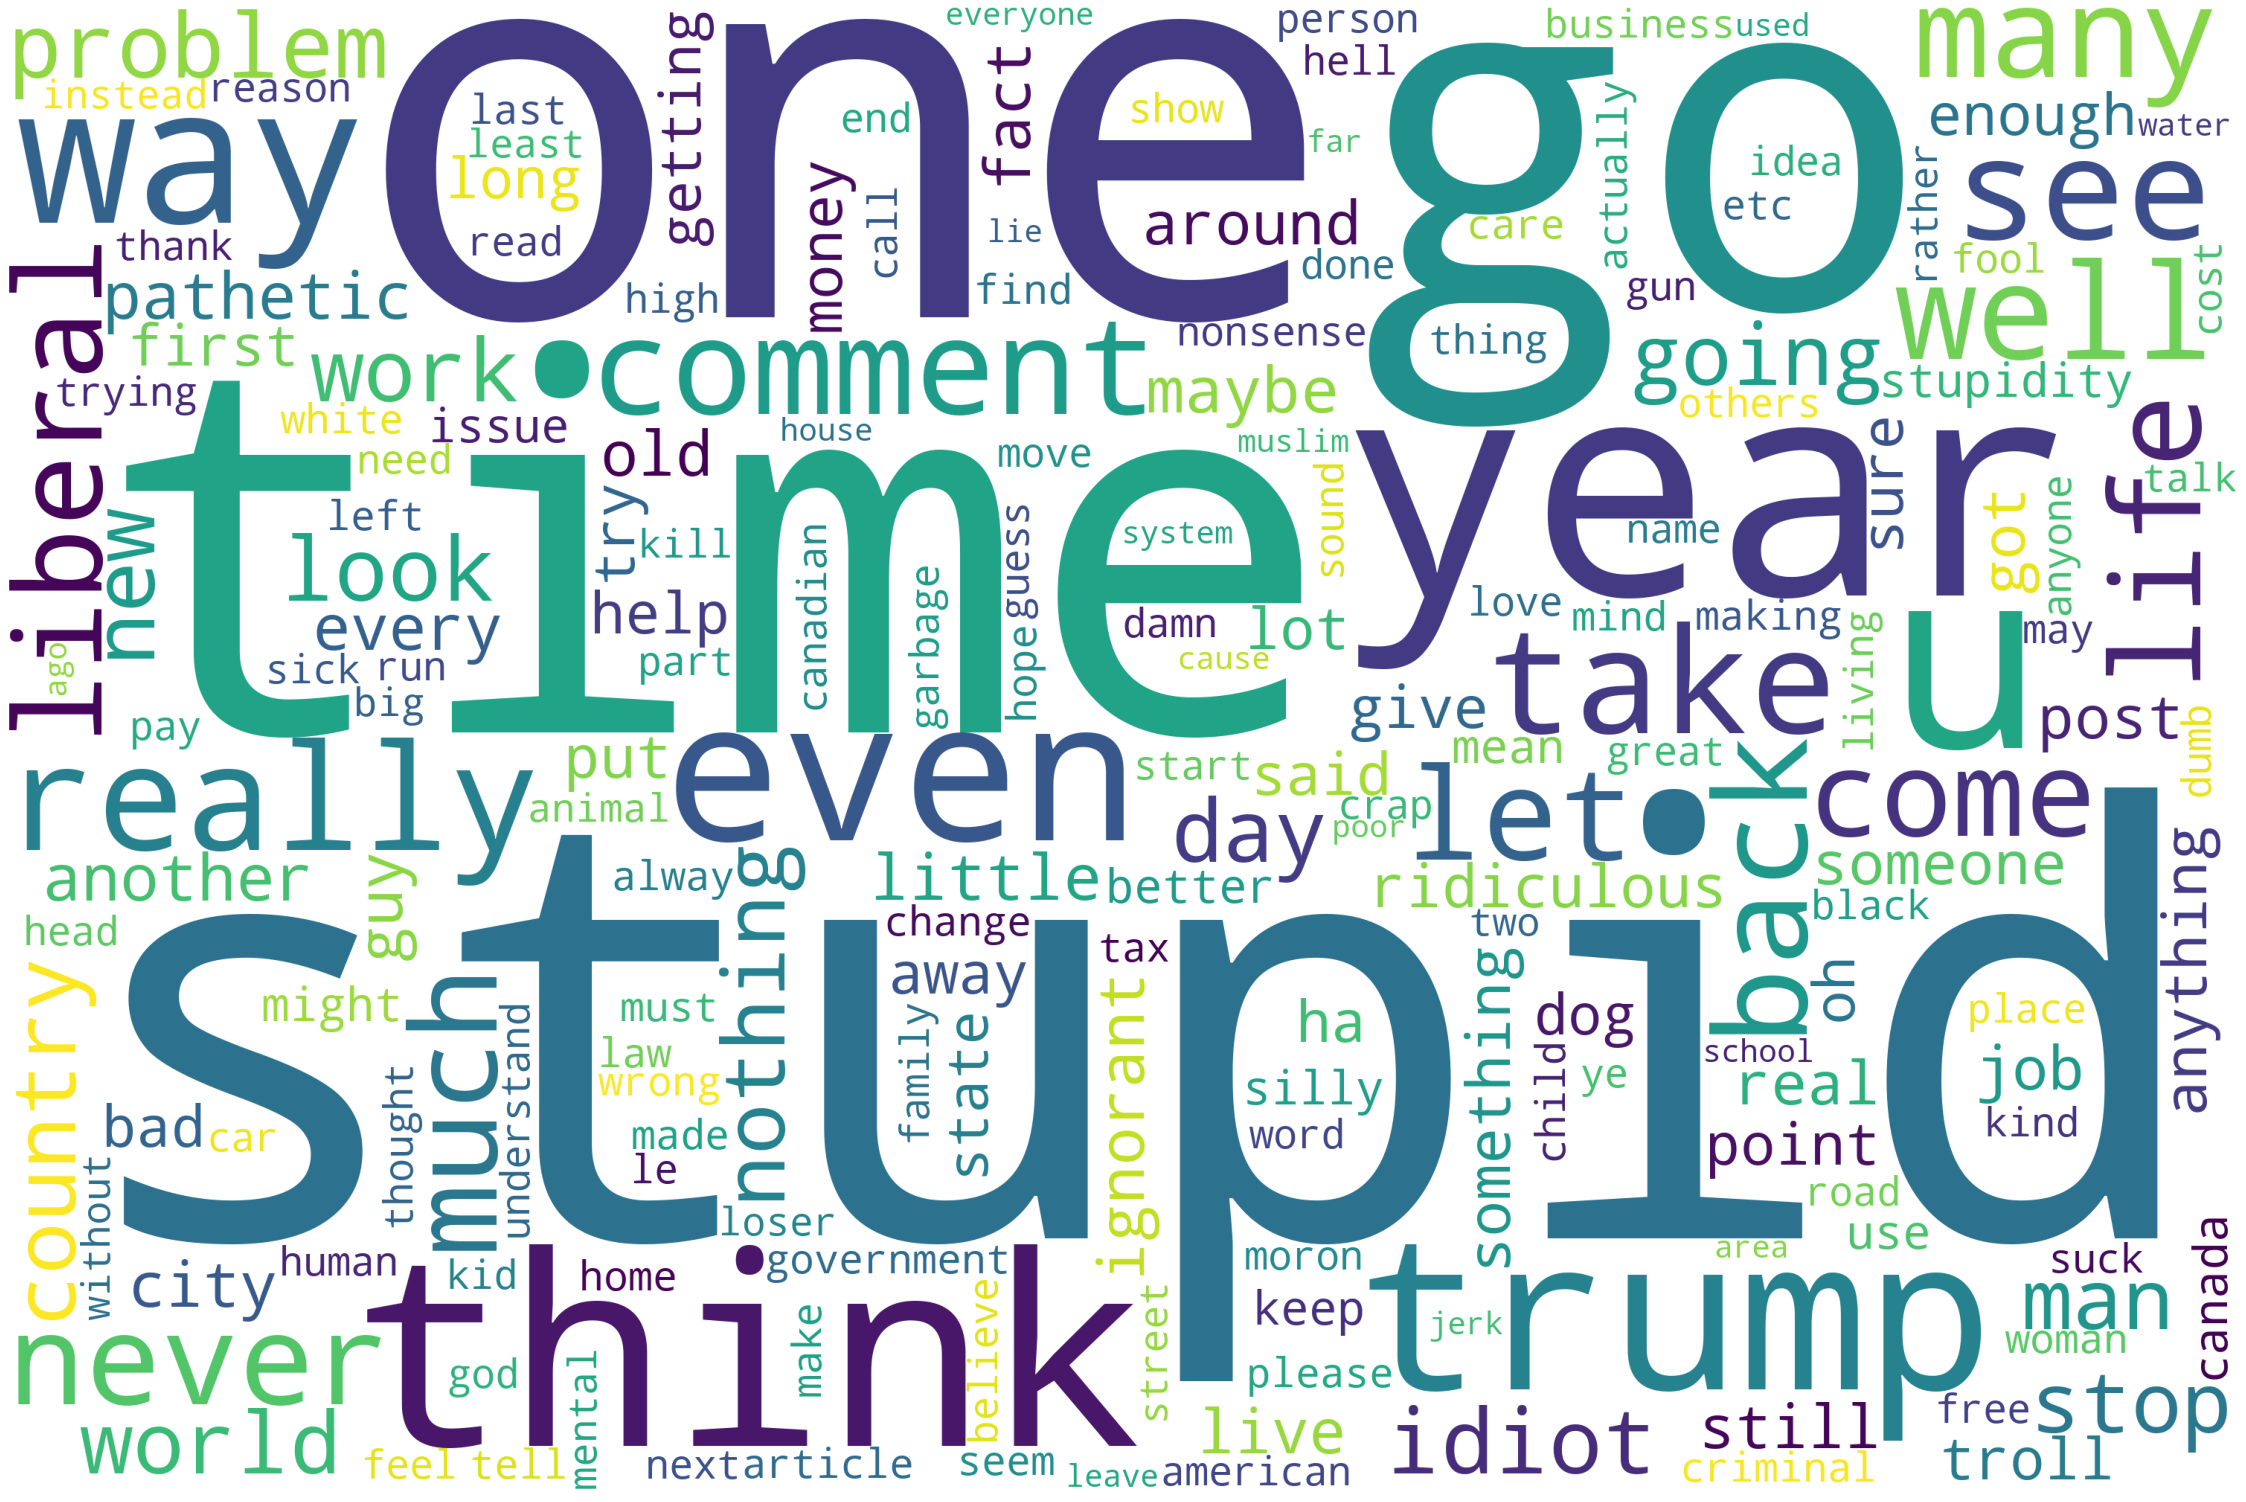

In [5]:
plt.figure(figsize= (40,30))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()